In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/moshida/EUVlitho


In [2]:
import numpy as np
from elitho import diffraction_amplitude, const, descriptors, diffraction_order, source

dod_narrow = descriptors.DiffractionOrderDescriptor(1.5)
dod_wide = descriptors.DiffractionOrderDescriptor(6.0)
doc_narrow = diffraction_order.DiffractionOrderCoordinate(
        dod_narrow.max_diffraction_order_x,
        dod_narrow.max_diffraction_order_y,
        diffraction_order.ellipse,
)
doc_wide = diffraction_order.DiffractionOrderCoordinate(
        dod_wide.max_diffraction_order_x,
        dod_wide.max_diffraction_order_y,
        diffraction_order.rounded_diamond,
)

/home/moshida/.pyenv/versions/3.12.11/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from elitho.pupil import find_valid_pupil_points
linput, minput, xinput, n_input = find_valid_pupil_points(doc_wide.num_valid_diffraction_orders)
n_input, np.sum(xinput >= 8)

(105, np.int64(45))

In [4]:
dkx, dky, SDIV = source.uniform_k_source()

In [5]:
import numpy as np

TCCXS0 = np.zeros((n_input, n_input), dtype=np.complex128)
TCCXSX = np.zeros((n_input, n_input), dtype=np.complex128)
TCCXSY = np.zeros((n_input, n_input), dtype=np.complex128)
TCCYS0 = np.zeros((n_input, n_input), dtype=np.complex128)
TCCYSX = np.zeros((n_input, n_input), dtype=np.complex128)
TCCYSY = np.zeros((n_input, n_input), dtype=np.complex128)

pmax = (const.k * const.NA) ** 2
for i in range(n_input):
    kx = 2 * np.pi / const.dx * linput[i]
    ky = 2 * np.pi / const.dy * minput[i]

    for j in range(i + 1):  # j <= i
        kxp = 2 * np.pi / const.dx * linput[j]
        kyp = 2 * np.pi / const.dy * minput[j]

        sumx_s0 = 0 + 0j
        sumy_s0 = 0 + 0j
        sumx_sx = 0 + 0j
        sumy_sx = 0 + 0j
        sumx_sy = 0 + 0j
        sumy_sy = 0 + 0j

        for is_ in range(SDIV):
            sx = dkx[is_]
            sy = dky[is_]

            ksx  = kx  + sx
            ksy  = ky  + sy
            ksxp = kxp + sx
            ksyp = kyp + sy

            if ((const.MX**2 * ksx**2 + const.MY**2 * ksy**2) <= pmax and
                (const.MX**2 * ksxp**2 + const.MY**2 * ksyp**2) <= pmax):

                phase  = np.exp(const.i_complex * ((ksx  + const.kx0)**2 + (ksy  + const.ky0)**2) / (2 * const.k) * const.z0)
                phasep = np.exp(const.i_complex * ((ksxp + const.kx0)**2 + (ksyp + const.ky0)**2) / (2 * const.k) * const.z0)

                denom_x = (const.k**2 - (const.kx0 + sx)**2)
                denom_y = (const.k**2 - (const.ky0 + sy)**2)

                sumx_s0 += phase * phasep.conjugate() / denom_x
                sumy_s0 += phase * phasep.conjugate() / denom_y
                sumx_sx += sx * phase * phasep.conjugate() / denom_x
                sumy_sx += sx * phase * phasep.conjugate() / denom_y
                sumx_sy += sy * phase * phasep.conjugate() / denom_x
                sumy_sy += sy * phase * phasep.conjugate() / denom_y

        TCCXS0[i, j] = sumx_s0 / SDIV
        TCCXS0[j, i] = TCCXS0[i, j].conjugate()
        TCCXSX[i, j] = sumx_sx / SDIV
        TCCXSX[j, i] = TCCXSX[i, j].conjugate()
        TCCXSY[i, j] = sumx_sy / SDIV
        TCCXSY[j, i] = TCCXSY[i, j].conjugate()
        TCCYS0[i, j] = sumy_s0 / SDIV
        TCCYS0[j, i] = TCCYS0[i, j].conjugate()
        TCCYSX[i, j] = sumy_sx / SDIV
        TCCYSX[j, i] = TCCYSX[i, j].conjugate()
        TCCYSY[i, j] = sumy_sy / SDIV
        TCCYSY[j, i] = TCCYSY[i, j].conjugate()


In [6]:
import numpy as np

def compute_eigen_decomp(mat):
    alpha, eigvecs = np.linalg.eigh(mat)
    # NOTE: 転置がいるかどうかは要確認 
    # -> 次の次のセルで, [i, :]でアクセスしているので転置していてOK
    phip = eigvecs.T.copy()
    return alpha, phip


# 各行列に対して固有値分解
alphaXs0, phipXs0 = compute_eigen_decomp(TCCXS0)
alphaXsx, phipXsx = compute_eigen_decomp(TCCXSX)
alphaXsy, phipXsy = compute_eigen_decomp(TCCXSY)

alphaYs0, phipYs0 = compute_eigen_decomp(TCCYS0)
alphaYsx, phipYsx = compute_eigen_decomp(TCCYSX)
alphaYsy, phipYsy = compute_eigen_decomp(TCCYSY)


In [7]:
alphaYsy.shape, phipYsy.shape, 

((105,), (105, 105))

In [8]:
phiXs0 = np.zeros((n_input, n_input), dtype=np.complex128)
phiXsx = np.zeros_like(phiXs0)
phiXsy = np.zeros_like(phiXs0)
phiYs0 = np.zeros_like(phiXs0)
phiYsx = np.zeros_like(phiXs0)
phiYsy = np.zeros_like(phiXs0)

xs0 = np.arange(n_input)
xsx = np.arange(n_input)
xsy = np.arange(n_input)
ys0 = np.arange(n_input)
ysx = np.arange(n_input)
ysy = np.arange(n_input)

# Reorder both the eigenvalues and the eigenvectors based on the magnitude of the eigenvalues.
idx_xs0 = xs0[np.argsort(-np.abs(alphaXs0))]
idx_xsx = xsx[np.argsort(-np.abs(alphaXsx))]
idx_xsy = xsy[np.argsort(-np.abs(alphaXsy))]
idx_ys0 = ys0[np.argsort(-np.abs(alphaYs0))]
idx_ysx = ysx[np.argsort(-np.abs(alphaYsx))]
idx_ysy = ysy[np.argsort(-np.abs(alphaYsy))]

# eigenvalues
alphaXs0 = alphaXs0[idx_xs0]
alphaXsx = alphaXsx[idx_xsx]
alphaXsy = alphaXsy[idx_xsy]
alphaYs0 = alphaYs0[idx_ys0]
alphaYsx = alphaYsx[idx_ysx]
alphaYsy = alphaYsy[idx_ysy]

# eigenvectors
phiXs0 = phipXs0[idx_xs0]
phiXsx = phipXsx[idx_xsx]
phiXsy = phipXsy[idx_xsy]
phiYs0 = phipYs0[idx_ys0]
phiYsx = phipYsx[idx_ysx]
phiYsy = phipYsy[idx_ysy]

In [9]:
amp_absorber, amp_vacuum, phasexx = diffraction_amplitude.zero_order_amplitude("X", dod_wide, doc_narrow)

/home/moshida/EUVlitho/elitho/diffraction_amplitude.py:172: RuntimeWarning: invalid value encountered in scalar divide
  phasexx[x, y] = vcxx[x, y] / np.abs(vcxx[x, y])


In [10]:
from elitho.mask_pattern import LinePattern
from elitho import const
mask = LinePattern(cd=80, gap=60, direction="V", field_type="DF")(const.NDIVX, const.NDIVY)

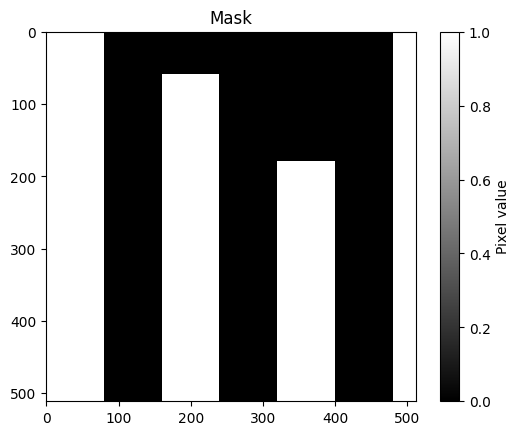

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(mask, cmap='gray', interpolation='nearest')
plt.title("Mask")
plt.colorbar(label="Pixel value")
plt.show()

In [12]:
hfpattern = mask * (amp_absorber - amp_vacuum) + amp_vacuum

In [13]:
# fft with scaling
fft_mask = np.fft.fft2(hfpattern, norm="forward")

In [14]:
fmask = np.zeros((const.noutX, const.noutY), dtype=np.complex128)
# NOTE: NDIVX, NDIVYはもともとFDIVX, FDIVYという名前
for i in range(const.noutX):
    l = (i - const.lpmaxX + const.NDIVX) % const.NDIVX
    for j in range(const.noutY):
        m = (j - const.lpmaxY + const.NDIVY) % const.NDIVY
        fmask[i, j] = fft_mask[l, m]

In [15]:
fampxx = np.zeros((const.noutX, const.noutY), dtype=np.complex128)
for ip in range(const.noutX):
    for jp in range(const.noutY):
        kxp = 2.0 * np.pi * (ip - const.lpmaxX) / const.dx
        kyp = 2.0 * np.pi * (jp - const.lpmaxY) / const.dy
        phasesp = np.exp(-const.i_complex * (const.kx0*kxp + kxp**2/2 + const.ky0*kyp + kyp**2/2) / (const.k * const.z0))
        fampxx[ip, jp] = fmask[ip, jp] * phasesp

In [16]:
fampxx /= phasexx

In [17]:
params = np.load("assets/params/m3d.npz")
d0, dx, dy = params["d0"], params["dx"], params["dy"]
a0xx = np.zeros((const.noutX, const.noutY), dtype=np.complex128)
axxx = np.zeros_like(a0xx)
ayxx = np.zeros_like(a0xx)
for n in range(n_input):
    ip = linput[n] + const.lpmaxX
    jp = minput[n] + const.lpmaxY
    a0xx[ip, jp] = d0[n]
    if xinput[n] >= 8:
        axxx[ip, jp] = dx[n]
        ayxx[ip, jp] = dy[n]

In [18]:
from enum import Enum
class SimulationMode(Enum):
    FAST = 1
    PRECISE = 2
    
# sim_mode = SimulationMode.FT
sim_mode = SimulationMode.PRECISE # STCC_SOCKSにはPRECISEしかなさそう？

In [19]:
import numpy as np

# 複素単位
zi = 1j
polar = "X"

# Pythonのリストを複素数配列で初期化
Exs0 = np.zeros(n_input, dtype=complex)
Eys0 = np.zeros(n_input, dtype=complex)
Ezs0 = np.zeros(n_input, dtype=complex)
Exsx = np.zeros(n_input, dtype=complex)
Eysx = np.zeros(n_input, dtype=complex)
Ezsx = np.zeros(n_input, dtype=complex)
Exsy = np.zeros(n_input, dtype=complex)
Eysy = np.zeros(n_input, dtype=complex)
Ezsy = np.zeros(n_input, dtype=complex)
Exsxy = np.zeros(n_input, dtype=complex)
Eysxy = np.zeros(n_input, dtype=complex)
Ezsxy = np.zeros(n_input, dtype=complex)

# intensity配列（空間分布用）
intensity = np.zeros((const.XDIV, const.XDIV))

# 各空間周波数成分ごとに電場成分を計算
for i in range(n_input):

    # --- 1) 波数ベクトル(kx, ky, kz) 計算 ---
    kxplus = const.kx0 + 2 * np.pi * linput[i] / const.dx / 2.0
    kyplus = const.ky0 + 2 * np.pi * minput[i] / const.dy / 2.0

    # kzはEvanescentを含むので負の平方根
    kzplus = -np.sqrt(const.k*const.k - kxplus*kxplus - kyplus*kyplus)

    # 周波数インデックス (wrap)
    ip = linput[i] + const.lpmaxX
    jp = minput[i] + const.lpmaxY
    lp = ip - const.lpmaxX
    mp = jp - const.lpmaxY

    # 電場スペクトル Ax or Ay (偏光成分)
    if polar == "X":  # X偏光
        if sim_mode == SimulationMode.FAST:
            Ax = fampxx[ip, jp]
            dxAx = 0.0
            dyAx = 0.0
        elif sim_mode == SimulationMode.PRECISE:
            Ax = fampxx[ip, jp] + a0xx[ip, jp]
            dxAx = axxx[ip, jp] * const.dx / (2 * np.pi)
            dyAx = ayxx[ip, jp] * const.dy / (2 * np.pi)
        else:
            raise ValueError("sim_mode must be 'FAST' or 'PRECISE'")

        # --- 2) ベクトル回折式のテイラー展開 ---
        Exs0[i] = zi*const.k*Ax - zi/const.k * kxplus*kxplus * Ax
        Exsx[i] = -2*zi/const.k*kxplus*Ax + zi*const.k*dxAx - zi/const.k*kxplus*kxplus*dxAx
        Exsy[i] = zi*const.k*dyAx - zi/const.k*kxplus*kxplus*dyAx
        Exsxy[i] = Exsx[i] / (const.dx/(2*np.pi)) * lp/2 + Exsy[i] / (const.dy/(2*np.pi)) * mp/2

        Eys0[i] = -zi/const.k * kxplus*kyplus * Ax
        Eysx[i] = -zi/const.k*kyplus*Ax - zi/const.k*kxplus*kyplus * dxAx
        Eysy[i] = -zi/const.k*kxplus*Ax - zi/const.k*kxplus*kyplus * dyAx
        Eysxy[i] = Eysx[i] / (const.dx/(2*np.pi)) * lp/2 + Eysy[i] / (const.dy/(2*np.pi)) * mp/2

        Ezs0[i] = -zi/const.k*kxplus*kzplus * Ax
        Ezsx[i] = -zi/const.k*kzplus*Ax - zi/const.k*kxplus*kzplus*dxAx
        Ezsy[i] = -zi/const.k*kxplus*kzplus * dyAx
        Ezsxy[i] = Ezsx[i] / (const.dx/(2*np.pi)) * lp/2 + Ezsy[i] / (const.dy/(2*np.pi)) * mp/2

    elif polar == "Y":  # Y偏光
        if sim_mode == SimulationMode.FAST:
            Ay = fampxx[ip, jp]
            dxAy = 0.0
            dyAy = 0.0
        elif sim_mode == SimulationMode.PRECISE:
            Ay = fampxx[ip, jp] + a0xx[ip, jp]
            dxAy = axxx[ip, jp] * dx / (2*np.pi)
            dyAy = ayxx[ip, jp] * dy / (2*np.pi)
        else:
            raise ValueError("sim_mode must be 'FAST' or 'PRECISE'")

        Exs0[i] = -zi/const.k * kxplus*kyplus * Ay
        Exsx[i] = -zi/const.k*kyplus*Ay - zi/const.k*kxplus*kyplus * dxAy
        Exsy[i] = -zi/const.k*kxplus*Ay - zi/const.k*kxplus*kyplus * dyAy
        Exsxy[i] = Exsx[i] / (dx/(2*np.pi)) * lp/2 + Exsy[i] / (dy/(2*np.pi)) * mp/2

        Eys0[i] = zi/const.k*Ay - zi/const.k*kyplus*kyplus * Ay
        Eysx[i] = zi/const.k*dxAy - zi/const.k*kyplus*kyplus * dxAy
        Eysy[i] = -2*zi/const.k*kyplus*Ay + zi/const.k*dyAy - zi/const.k*kyplus*kyplus*dyAy
        Eysxy[i] = Eysx[i] / (dx/(2*np.pi)) * lp/2 + Eysy[i] / (dy/(2*np.pi)) * mp/2

        Ezs0[i] = -zi/const.k*kyplus*kzplus * Ay
        Ezsx[i] = -zi/const.k*kyplus*kzplus * dxAy
        Ezsy[i] = -zi/const.k*kzplus*Ay - zi/const.k*kyplus*kzplus * dyAy
        Ezsxy[i] = Ezsx[i] / (dx/(2*np.pi)) * lp/2 + Ezsy[i] / (dy/(2*np.pi)) * mp/2
    else:
        raise ValueError("polar must be 'X' or 'Y'")


In [20]:
# socs parameters ... ?
nout = 64
nsocs = 100
nsocsxy = 20

In [21]:
intsmall = np.zeros((nout, nout), dtype=np.complex128)

for m in range(nsocs):
    fnxs0 = np.zeros((nout, nout), dtype=np.complex128)
    fnys0 = np.zeros((nout, nout), dtype=np.complex128)
    fnzs0 = np.zeros((nout, nout), dtype=np.complex128)
    
    for n in range(n_input):
        if polar == "X":
            fxs0 = Exs0[n] * phiXs0[m, n]
            fys0 = Eys0[n] * phiXs0[m, n]
            fzs0 = Ezs0[n] * phiXs0[m, n]
        elif polar == "Y":
            fxs0 = Exs0[n] * phiYs0[m, n]
            fys0 = Eys0[n] * phiYs0[m, n]
            fzs0 = Ezs0[n] * phiYs0[m, n]
        else:
            raise ValueError("polar must be 'X' or 'Y'")
        
        ix, iy = linput[n], minput[n]
        px, py = (ix + nout) % nout, (iy + nout) % nout
        
        fnxs0[px, py] = fxs0
        fnys0[px, py] = fys0
        fnzs0[px, py] = fzs0
        
    # ifft without scaling
    fnxs0_ifft = np.fft.ifft2(fnxs0, norm="forward")
    fnys0_ifft = np.fft.ifft2(fnys0, norm="forward")
    fnzs0_ifft = np.fft.ifft2(fnzs0, norm="forward")
    
    if polar == "X":
        alphas0 = alphaXs0[m]
    elif polar == "Y":
        alphas0 = alphaYs0[m]
    else:
        raise ValueError("polar must be 'X' or 'Y'")
    
    intsmall += alphas0 * (
        np.abs(fnxs0_ifft)**2 +
        np.abs(fnys0_ifft)**2 +
        np.abs(fnzs0_ifft)**2
    )
    
    if m <= nsocsxy:
        shape = (nout, nout)
        fnxs0x  = np.zeros(shape, dtype=np.complex128)
        fnys0x  = np.zeros(shape, dtype=np.complex128)
        fnzs0x  = np.zeros(shape, dtype=np.complex128)
        fnxs0y  = np.zeros(shape, dtype=np.complex128)
        fnys0y  = np.zeros(shape, dtype=np.complex128)
        fnzs0y  = np.zeros(shape, dtype=np.complex128)
        fnxsx   = np.zeros(shape, dtype=np.complex128)
        fnysx   = np.zeros(shape, dtype=np.complex128)
        fnzsx   = np.zeros(shape, dtype=np.complex128)
        fnxsy   = np.zeros(shape, dtype=np.complex128)
        fnysy   = np.zeros(shape, dtype=np.complex128)
        fnzsy   = np.zeros(shape, dtype=np.complex128)
        fnxsxy  = np.zeros(shape, dtype=np.complex128)
        fnysxy  = np.zeros(shape, dtype=np.complex128)
        fnzsxy  = np.zeros(shape, dtype=np.complex128)
        
        # === scatter fill from mode m ===
        for n in range(n_input):
            if polar == "X":
                fxs0x = Exs0[n] * phiXsx[m, n]
                fxs0y = Exs0[n] * phiXsy[m, n]
                fxsx  = Exsx[n] * phiXsx[m, n]
                fxsy  = Exsy[n] * phiXsy[m, n]
                fxsxy = Exsxy[n]* phiXs0[m, n]
                fys0x = Eys0[n] * phiXsx[m, n]
                fys0y = Eys0[n] * phiXsy[m, n]
                fysx  = Eysx[n] * phiXsx[m, n]
                fysy  = Eysy[n] * phiXsy[m, n]
                fysxy = Eysxy[n]* phiXs0[m, n]
                fzs0x = Ezs0[n] * phiXsx[m, n]
                fzs0y = Ezs0[n] * phiXsy[m, n]
                fzsx  = Ezsx[n] * phiXsx[m, n]
                fzsy  = Ezsy[n] * phiXsy[m, n]
                fzsxy = Ezsxy[n]* phiXs0[m, n]
            elif polar == "Y":
                fxs0x = Exs0[n] * phiYsx[m, n]
                fxs0y = Exs0[n] * phiYsy[m, n]
                fxsx  = Exsx[n] * phiYsx[m, n]
                fxsy  = Exsy[n] * phiYsy[m, n]
                fxsxy = Exsxy[n]* phiYs0[m, n]
                fys0x = Eys0[n] * phiYsx[m, n]
                fys0y = Eys0[n] * phiYsy[m, n]
                fysx  = Eysx[n] * phiYsx[m, n]
                fysy  = Eysy[n] * phiYsy[m, n]
                fysxy = Eysxy[n]* phiYs0[m, n]
                fzs0x = Ezs0[n] * phiYsx[m, n]
                fzs0y = Ezs0[n] * phiYsy[m, n]
                fzsx  = Ezsx[n] * phiYsx[m, n]
                fzsy  = Ezsy[n] * phiYsy[m, n]
                fzsxy = Ezsxy[n]* phiYs0[m, n]
            else:
                raise ValueError("polar must be 'X' or 'Y'")

            px = (linput[n] + nout) % nout
            py = (minput[n] + nout) % nout

            fnxs0x[px, py] = fxs0x
            fnys0x[px, py] = fys0x
            fnzs0x[px, py] = fzs0x
            fnxs0y[px, py] = fxs0y
            fnys0y[px, py] = fys0y
            fnzs0y[px, py] = fzs0y
            fnxsx[px, py]  = fxsx
            fnysx[px, py]  = fysx
            fnzsx[px, py]  = fzsx
            fnxsy[px, py]  = fxsy
            fnysy[px, py]  = fysy
            fnzsy[px, py]  = fzsy
            fnxsxy[px, py] = fxsxy
            fnysxy[px, py] = fysxy
            fnzsxy[px, py] = fzsxy

        # === inverse FFT ===
        fnxs0x  = np.fft.ifft2(fnxs0x)
        fnys0x  = np.fft.ifft2(fnys0x)
        fnzs0x  = np.fft.ifft2(fnzs0x)
        fnxs0y  = np.fft.ifft2(fnxs0y)
        fnys0y  = np.fft.ifft2(fnys0y)
        fnzs0y  = np.fft.ifft2(fnzs0y)
        fnxsx   = np.fft.ifft2(fnxsx)
        fnysx   = np.fft.ifft2(fnysx)
        fnzsx   = np.fft.ifft2(fnzsx)
        fnxsy   = np.fft.ifft2(fnxsy)
        fnysy   = np.fft.ifft2(fnysy)
        fnzsy   = np.fft.ifft2(fnzsy)
        fnxsxy  = np.fft.ifft2(fnxsxy)
        fnysxy  = np.fft.ifft2(fnysxy)
        fnzsxy  = np.fft.ifft2(fnzsxy)

        if polar == "X":
            alphasx = alphaXsx[m]
            alphasy = alphaXsy[m]
        elif polar == "Y":
            alphasx = alphaYsx[m]
            alphasy = alphaYsy[m]
        else:
            raise ValueError("polar must be 'X' or 'Y'")

        # === final combine ===
        intsmall += (
            2*alphasx * (
                fnxs0x*np.conj(fnxsx) +
                fnys0x*np.conj(fnysx) +
                fnzs0x*np.conj(fnzsx)
            )
            + 2*alphasy * (
                fnxs0y*np.conj(fnxsy) +
                fnys0y*np.conj(fnysy) +
                fnzs0y*np.conj(fnzsy)
            )
            + 2*alphas0 * (
                fnxs0*np.conj(fnxsxy) +
                fnys0*np.conj(fnysxy) +
                fnzs0*np.conj(fnzsxy)
            )
        ).real    
        

In [22]:
# fft without scaling
fft_intsmall = np.fft.fft2(intsmall)

In [ ]:
H = np.fft.fftshift(fft_intsmall)
# zero padding to XDIV x XDIV
Hpad = np.zeros((const.XDIV, const.XDIV), dtype=np.complex128)
x0 = (const.XDIV - nout) // 2
y0 = (const.XDIV - nout) // 2
Hpad[x0:x0+nout, y0:y0+nout] = H
Hpad = np.fft.ifftshift(Hpad)

In [30]:
intensity = np.fft.ifft2(Hpad)
intensity_real = np.real(intensity)/(nout * nout)


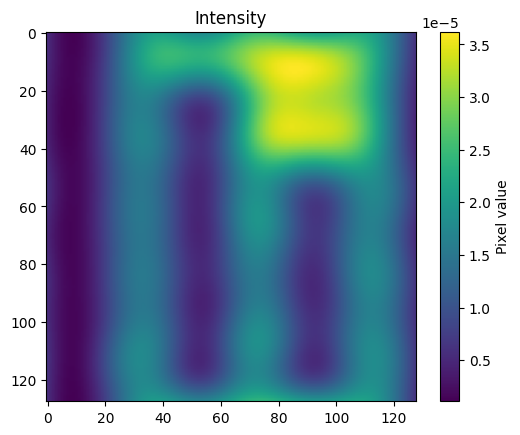

In [31]:
from matplotlib import pyplot as plt
plt.imshow(intensity_real)
plt.title("Intensity")
plt.colorbar(label="Pixel value")
plt.show()